# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Arguments" data-toc-modified-id="Arguments-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Arguments</a></div><div class="lev1 toc-item"><a href="#MetaCyc-subset-of-QM9" data-toc-modified-id="MetaCyc-subset-of-QM9-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>MetaCyc subset of QM9</a></div><div class="lev2 toc-item"><a href="#Delta-G^\circ_{QM9}-compounds-to-reactions" data-toc-modified-id="Delta-G^\circ_{QM9}-compounds-to-reactions-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>$\Delta G^\circ_{QM9}$ compounds to reactions</a></div><div class="lev1 toc-item"><a href="#Statistics" data-toc-modified-id="Statistics-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Statistics</a></div><div class="lev1 toc-item"><a href="#Define-model-and-optimizer" data-toc-modified-id="Define-model-and-optimizer-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Define model and optimizer</a></div><div class="lev1 toc-item"><a href="#Create-model" data-toc-modified-id="Create-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Create model</a></div><div class="lev1 toc-item"><a href="#get-the-best-checkpoint-if-available-without-training" data-toc-modified-id="get-the-best-checkpoint-if-available-without-training-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>get the best checkpoint if available without training</a></div><div class="lev2 toc-item"><a href="#Delta-G^\circ_{rxn}(DFT)-vs-\Delta-G^\circ_{rxn}(GCM)" data-toc-modified-id="Delta-G^\circ_{rxn}(DFT)-vs-\Delta-G^\circ_{rxn}(GCM)-61"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>$\Delta G^\circ_{rxn}(DFT)$ vs $\Delta G^\circ_{rxn}(GCM)$</a></div><div class="lev2 toc-item"><a href="#Delta-G^\circ_{rxn}(DFT)-vs-\Delta-G^\circ_{rxn}(MPNNv2,chemgraph)" data-toc-modified-id="Delta-G^\circ_{rxn}(DFT)-vs-\Delta-G^\circ_{rxn}(MPNNv2,chemgraph)-62"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>$\Delta G^\circ_{rxn}(DFT)$ vs $\Delta G^\circ_{rxn}$(MPNNv2,chemgraph)</a></div>

In [3]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.autograd import Variable

import time
import argparse
import os
import numpy as np
import sys
sys.path.append(os.getcwd())
# Our Modules
import utils
from utils import datasets
from models.MPNN import MPNN
from models.MPNNv2 import MPNNv2
from models.MPNNv3 import MPNNv3
from utils.LogMetric import AverageMeter, Logger


# Arguments

In [4]:
parser = argparse.ArgumentParser(description='Neural message passing')

parser.add_argument('--dataset', default='qm9', help='QM9')
parser.add_argument('--edge-rep', default='raw_distance', choices=['raw_distance','chem_graph','distance_bin'] )
parser.add_argument('--datasetPath', default='./mpnn-data/qm9/dsgdb9nsd/', help='dataset path')
parser.add_argument('--logPath', default='./log/qm9/mpnn/', help='log path')
parser.add_argument('--plotLr', default=False, help='allow plotting the data')
parser.add_argument('--plotPath', default='./plot/qm9/mpnn/', help='plot path')
parser.add_argument('--resume', default='./checkpoint/qm9/mpnn/',
                    help='path to latest checkpoint')
# Optimization Options
parser.add_argument('--batch-size', type=int, default=500, metavar='N',
                    help='Input batch size for training (default: 20)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='Enables CUDA training')
parser.add_argument('--epochs', type=int, default=50, metavar='N',
                    help='Number of epochs to train (default: 50)')
parser.add_argument('--lr', type=lambda x: restricted_float(x, [1e-5, 1e-2]), default=1e-3, metavar='LR',
                    help='Initial learning rate [1e-5, 5e-4] (default: 1e-4)')
parser.add_argument('--lr-decay', type=lambda x: restricted_float(x, [.01, 1]), default=0.6, metavar='LR-DECAY',
                    help='Learning rate decay factor [.01, 1] (default: 0.6)')
parser.add_argument('--schedule', type=list, default=[0.1, 0.9], metavar='S',
                    help='Percentage of epochs to start the learning rate decay [0, 1] (default: [0.1, 0.9])')
parser.add_argument('--momentum', type=float, default=0.9, metavar='M',
                    help='SGD momentum (default: 0.9)')
# i/o
parser.add_argument('--log-interval', type=int, default=20, metavar='N',
                    help='How many batches to wait before logging training status')
# Accelerating
parser.add_argument('--prefetch', type=int, default=2, help='Pre-fetching threads.')

# Model modification
parser.add_argument('--model', type=str,help='MPNN model name [MPNN, MPNNv2, MPNNv3]',
                        default='MPNN')


args = parser.parse_args(['--model','MPNNv2', '--edge-rep','chem_graph',]) #'--no-cuda'])
print(args)


Namespace(batch_size=500, dataset='qm9', datasetPath='./mpnn-data/qm9/dsgdb9nsd/', edge_rep='chem_graph', epochs=50, logPath='./log/qm9/mpnn/', log_interval=20, lr=0.001, lr_decay=0.6, model='MPNNv2', momentum=0.9, no_cuda=False, plotLr=False, plotPath='./plot/qm9/mpnn/', prefetch=2, resume='./checkpoint/qm9/mpnn/', schedule=[0.1, 0.9])


In [5]:
def restricted_float(x, inter):
    x = float(x)
    if x < inter[0] or x > inter[1]:
        raise argparse.ArgumentTypeError("%r not in range [1e-5, 1e-4]"%(x,))
    return x


In [6]:

best_er1 = 0

    # Check if CUDA is enabled
args.cuda = not args.no_cuda and torch.cuda.is_available()

    # Load data
root = args.datasetPath
root

'./mpnn-data/qm9/dsgdb9nsd/'

# MetaCyc subset of QM9

In [7]:
print('Prepare files')
import pandas as pd
qm9_metacyc = pd.read_table('Dataset/QM9_metacyc.tab')
qm9_metacyc

Prepare files


,FrameId,Name,Kegg,InChI,Smiles,Gibbs-0,cpd,nC
0,BUTYRAMIDE,butyramide,NIL,"InChI=1S/C4H9NO/c1-2-3-4(5)6/h2-3H2,1H3,(H2,5,6)",CCCC(N)=O,51.370094,./dsgdb9nsd_000262.xyz,4
1,CPD-282,cyclohex-2-enone,C02395,"InChI=1S/C6H8O/c7-6-4-2-1-3-5-6/h2,4H,1,3,5H2",C1(CCC(C=C1)=O),76.978966,./dsgdb9nsd_002060.xyz,6
2,CPD-7031,3-methylbutanal,C07329,"InChI=1S/C5H10O/c1-5(2)3-4-6/h4-5H,3H2,1-2H3",CC(C)C[CH]=O,71.711205,./dsgdb9nsd_000255.xyz,5
3,CPD-9383,glycine methyl ester,NIL,"InChI=1S/C3H7NO2/c1-6-3(5)2-4/h2,4H2,1H3",C([NH2])C(=O)OC,-3.392161,./dsgdb9nsd_000365.xyz,3
4,CYTOSINE,cytosine,C00380,"InChI=1S/C4H5N3O/c5-3-1-2-6-4(8)7-3/h1-2H,(H3,...",C1(NC(=O)N=C(N)C=1),19.905600,./dsgdb9nsd_004243.xyz,4
5,CYTOSINE,cytosine,C00380,"InChI=1S/C4H5N3O/c5-3-1-2-6-4(8)7-3/h1-2H,(H3,...",C1(NC(=O)N=C(N)C=1),19.905600,./dsgdb9nsd_004318.xyz,4
6,CYTOSINE,cytosine,C00380,"InChI=1S/C4H5N3O/c5-3-1-2-6-4(8)7-3/h1-2H,(H3,...",C1(NC(=O)N=C(N)C=1),19.905600,./dsgdb9nsd_004371.xyz,4
7,CYTOSINE,cytosine,C00380,"InChI=1S/C4H5N3O/c5-3-1-2-6-4(8)7-3/h1-2H,(H3,...",C1(NC(=O)N=C(N)C=1),19.905600,./dsgdb9nsd_004403.xyz,4
8,URACIL,uracil,C00106,"InChI=1S/C4H4N2O2/c7-3-1-2-5-4(8)6-3/h1-2H,(H2...",C1(=CC(NC(=O)N1)=O),-28.995518,./dsgdb9nsd_004258.xyz,4
9,URACIL,uracil,C00106,"InChI=1S/C4H4N2O2/c7-3-1-2-5-4(8)6-3/h1-2H,(H2...",C1(=CC(NC(=O)N1)=O),-28.995518,./dsgdb9nsd_004294.xyz,4


## Read all files, split into train, test, validation sets

In [ ]:
files = [f for f in os.listdir(root) if os.path.isfile(os.path.join(root, f))]

idx = np.random.permutation(len(files))
idx = idx.tolist()
idx

ERROR: Internal Python error in the inspect module.
Below is the traceback from this internal error.


Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
  File "/people/zuck016/.pyenv/versions/anaconda3-2.5.0/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3066, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-959ac950a0a3>", line 1, in <module>
    files = [f for f in os.listdir(root) if os.path.isfile(os.path.join(root, f))]
  File "<ipython-input-8-959ac950a0a3>", line 1, in <listcomp>
    files = [f for f in os.listdir(root) if os.path.isfile(os.path.join(root, f))]
  File "/people/zuck016/.pyenv/versions/anaconda3-2.5.0/lib/python3.5/genericpath.py", line 30, in isfile
    st = os.stat(path)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/people/zuck016/.pyenv/versions/anaconda3-2.5.0/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 1877, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object 

ERROR: Internal Python error in the inspect module.
Below is the traceback from this internal error.


Unfortunately, your original traceback can not be constructed.



In [11]:
valid_ids = [files[i] for i in idx[0:10000]]
test_ids = [files[i] for i in idx[10000:20000]]
train_ids = [files[i] for i in idx[20000:]]

data_train = utils.Qm9(root, train_ids, edge_transform=datasets.qm9_edges, e_representation=args.edge_rep)
data_valid = utils.Qm9(root, valid_ids, edge_transform=datasets.qm9_edges, e_representation=args.edge_rep)
data_test = utils.Qm9(root, test_ids, edge_transform=datasets.qm9_edges, e_representation=args.edge_rep)

In [12]:
print('Define model')
# Select one graph
g_tuple, l = data_train[0]
g, h_t, e = g_tuple

vals = utils.datasets.get_values(data_valid, 0, len(data_valid), ['target_mean','target_std'])
param = np.array([file_res['params'] for file_res in vals])
param

Define model


KeyboardInterrupt: 

In [13]:
print('\tStatistics')
stat_dict_valid = datasets.get_graph_stats(data_valid, ['target_mean', 'target_std'], multiprocess_p=True)
stat_dict_valid

	Statistics


{'target_mean': array([  2.71671202e+00,   7.51269150e+01,  -2.40173140e-01,
          9.94042000e-03,   2.50113100e-01,   1.18747535e+03,
          1.48324262e-01,  -4.11191528e+02,  -4.11183074e+02,
         -4.11182129e+02,  -4.11224913e+02,   3.15511499e+01]),
 'target_std': array([  1.55180646e+00,   8.24347866e+00,   2.21273174e-02,
          4.67165084e-02,   4.74818072e-02,   2.82924388e+02,
          3.33600257e-02,   4.09214368e+01,   4.09211962e+01,
          4.09211962e+01,   4.09219795e+01,   4.07823199e+00])}

In [ ]:
data_train.set_target_transform(lambda x: datasets.normalize_data(x,stat_dict_valid['target_mean'],
                                                                            stat_dict_valid['target_std']))
data_valid.set_target_transform(lambda x: datasets.normalize_data(x, stat_dict_valid['target_mean'],
                                                                            stat_dict_valid['target_std']))
data_test.set_target_transform(lambda x: datasets.normalize_data(x, stat_dict_valid['target_mean'],
                                                                           stat_dict_valid['target_std']))

In [ ]:
    train_loader = torch.utils.data.DataLoader(data_train,
                                               batch_size=args.batch_size, shuffle=True,
                                               collate_fn=datasets.collate_g,
                                               num_workers=args.prefetch, pin_memory=True)
    valid_loader = torch.utils.data.DataLoader(data_valid,
                                               batch_size=args.batch_size, collate_fn=datasets.collate_g,
                                               num_workers=args.prefetch, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(data_test,
                                              batch_size=args.batch_size, collate_fn=datasets.collate_g,
                                              num_workers=args.prefetch, pin_memory=True)


## $\Delta G^\circ_{QM9}$ compounds to reactions

In [8]:
qm9_metacyc_dict = qm9_metacyc.set_index('cpd').to_dict()['FrameId']
qm9_metacyc_dict

{'./dsgdb9nsd_000001.xyz': 'CH4',
 './dsgdb9nsd_000002.xyz': 'AMMONIA',
 './dsgdb9nsd_000003.xyz': 'WATER',
 './dsgdb9nsd_000004.xyz': 'ACETYLENE',
 './dsgdb9nsd_000005.xyz': 'HCN',
 './dsgdb9nsd_000006.xyz': 'FORMALDEHYDE',
 './dsgdb9nsd_000007.xyz': 'CPD-9312',
 './dsgdb9nsd_000008.xyz': 'METOH',
 './dsgdb9nsd_000009.xyz': 'CPD-19558',
 './dsgdb9nsd_000011.xyz': 'ACETALD',
 './dsgdb9nsd_000012.xyz': 'FORMAMIDE',
 './dsgdb9nsd_000013.xyz': 'CPD-18984',
 './dsgdb9nsd_000014.xyz': 'ETOH',
 './dsgdb9nsd_000017.xyz': 'CPD-19003',
 './dsgdb9nsd_000018.xyz': 'ACETONE',
 './dsgdb9nsd_000019.xyz': 'ACETAMIDE',
 './dsgdb9nsd_000020.xyz': 'UREA',
 './dsgdb9nsd_000021.xyz': 'CPD-19056',
 './dsgdb9nsd_000022.xyz': 'ISO-PROPANOL',
 './dsgdb9nsd_000026.xyz': 'CPD-15163',
 './dsgdb9nsd_000028.xyz': 'CPD-8887',
 './dsgdb9nsd_000031.xyz': 'CPD-8860',
 './dsgdb9nsd_000035.xyz': 'CPD-665',
 './dsgdb9nsd_000037.xyz': 'CPD-18959',
 './dsgdb9nsd_000038.xyz': 'GLYCOLALDEHYDE',
 './dsgdb9nsd_000039.xyz': 'CP

In [10]:
metacyc_files = [( qm9_metacyc_dict['./' + os.path.basename(f)], f ) 
                     for f in os.listdir(root) 
                         if os.path.isfile(os.path.join(root, f))
                            and 
                            './' + os.path.basename(f) 
                            in qm9_metacyc_dict]
dict(metacyc_files)

ERROR: Internal Python error in the inspect module.
Below is the traceback from this internal error.


Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
  File "/people/zuck016/.pyenv/versions/anaconda3-2.5.0/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3066, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-25b10d306490>", line 2, in <module>
    for f in os.listdir(root)
  File "<ipython-input-10-25b10d306490>", line 3, in <listcomp>
    if os.path.isfile(os.path.join(root, f))
  File "/people/zuck016/.pyenv/versions/anaconda3-2.5.0/lib/python3.5/genericpath.py", line 30, in isfile
    st = os.stat(path)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/people/zuck016/.pyenv/versions/anaconda3-2.5.0/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 1877, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another ex

TypeError: 'NoneType' object is not iterable

In [ ]:
qm9_metacyc_graphs = utils.Qm9(root,
                               sorted([f[2:] for f in qm9_metacyc_dict.keys()]),
                               edge_transform=datasets.qm9_edges, 
                               e_representation=args.edge_rep )
qm9_metacyc_vals = utils.datasets.get_values(qm9_metacyc_graphs, 
                                             0, 
                                             len(qm9_metacyc_graphs), 
                                             ['target_mean','target_std'])
qm9_metacyc_param = np.array([file_res['params'] for file_res in qm9_metacyc_vals])
qm9_metacyc_dG = pd.Series(qm9_metacyc_param[:,-2], 
                           index=[qm9_metacyc_dict[f] 
                                  for f in sorted(qm9_metacyc_dict)])
qm9_metacyc_dG.to_csv('Dataset/QM9_DFT_deltaG0f.tab',index=True, sep='\t')
qm9_metacyc_dG

In [9]:
qm9_metacyc_dG_min = qm9_metacyc_dG.reset_index().groupby('index').min().dropna()
qm9_metacyc_dG_min.columns = ['$\Delta G^\circ_f(DFT)$']
qm9_metacyc_dG_min

,$\Delta G^\circ_f(DFT)$
index,
2-5-DIHYDROXYPYRIDINE,-398.697434
2-AMINOPHENOL,-362.761949
2-BUTYNE-14-DIOL,-306.345991
2-DEHYDROPANTOYL-LACTONE,-459.053741
2-DEOXYRIBOSE,-497.331001
2-HYDROXY-2-METHYLPROPANENITRILE,-286.536500
2-HYDROXYPYRIDINE,-323.477888
2-METHOXYETHANOL,-269.494828
23-PENTANEDIONE,-345.729675


In [ ]:
stoich_matrix = pd.read_table('Dataset/QM9.S',index_col=['Rxn','Metabolite'])['Stoichiometry']
rxns, metabs = stoich_matrix.index.levels
stoich_dict = stoich_matrix.to_dict()
S = pd.DataFrame(0,index=metabs, columns=rxns)
for rxn,metab in stoich_dict:   
    S.loc[metab,rxn] = stoich_dict[rxn, metab]
#S.loc['3-HYDROXY-4H-PYRID-4-ONE','CREATINASE-RXN'] = 1
S

In [ ]:
deltaG = S.T.dot(qm9_metacyc_dG_min['$\Delta G^\circ_f(DFT)$'][metabs]).to_frame('$\Delta G^\circ_{rxn}(DFT)$')
deltaG

In [ ]:
deltaG

# Statistics

In [ ]:
print('\tStatistics')
stat_dict = datasets.get_graph_stats(qm9_metacyc_graphs, ['target_mean', 'target_std'], multiprocess_p=True)
stat_dict

# Define  metacyc model and optimizer


In [ ]:
print('Define model')
# Select one graph
g_tuple, l = metacyc_graphs[0]
g, h_t, e = g_tuple

vals = utils.datasets.get_values(metacyc_graphs, 0, len(metacyc_graphs), ['target_mean','target_std'])
param = np.array([file_res['params'] for file_res in vals])
param

In [ ]:
len(metacyc_graphs)

In [ ]:
metacyc_predict_loader = torch.utils.data.DataLoader(   metacyc_graphs,
                                                batch_size=args.batch_size,
                                                shuffle=False,
                                                collate_fn=datasets.collate_g,
                                                num_workers=args.prefetch,
                                                pin_memory=True)
for i, batch_sample in enumerate(metacyc_predict_loader):
    print(i, batch_sample)

# Define QM9 metacyc model and optimizer


In [ ]:
print('Define model')
# Select one graph
g_tuple, l = qm9_metacyc_graphs[0]
g, h_t, e = g_tuple

vals = utils.datasets.get_values(qm9_metacyc_graphs, 0, len(qm9_metacyc_graphs), ['target_mean','target_std'])
param = np.array([file_res['params'] for file_res in vals])
param

In [ ]:
len(qm9_metacyc_graphs)

In [ ]:
predict_loader = torch.utils.data.DataLoader(   qm9_metacyc_graphs,
                                                batch_size=len(qm9_metacyc_graphs),
                                                shuffle=False,
                                                collate_fn=datasets.collate_g,
                                                num_workers=args.prefetch,
                                                pin_memory=True)
#for i, batch_sample in enumerate(predict_loader):
#    print(i, batch_sample)

# Create MPNNv2 with chem_graph edge attributes model

In [ ]:
    in_n = [len(h_t[0]), len(list(e.values())[0])]
    hidden_state_size = 73
    message_size = 73
    n_layers = 3
    l_target = len(l)
    type ='regression'
    if args.model == 'MPNNv2':
        model = MPNNv2(in_n, [5, 15, 15], [10, 20, 20], l_target, type=type)
    elif args.model == 'MPNNv3':
        model = MPNNv3([1, 2, 3, 4], in_n, [5, 15, 15], 30, l_target, type=type)
    else:
        model = MPNN(in_n, hidden_state_size, message_size, n_layers, l_target, type=type)
    del in_n, hidden_state_size, message_size, n_layers, l_target, type

    print('Optimizer')
    optimizer = optim.Adam(model.parameters(), lr=args.lr)

    criterion = nn.MSELoss()

    evaluation = lambda output, target: torch.mean(torch.abs(output - target) / torch.abs(target))

    print('Logger')
    logger = Logger(args.logPath)

    lr_step = (args.lr-args.lr*args.lr_decay)/(args.epochs*args.schedule[1] - args.epochs*args.schedule[0])


# get the best checkpoint if available without training

In [ ]:
if args.resume:
        checkpoint_dir = args.resume
        best_model_file = os.path.join(checkpoint_dir, 'model_best.pth')
        if not os.path.isdir(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        if os.path.isfile(best_model_file):
            print("=> loading best model '{}'".format(best_model_file))
            checkpoint = torch.load(best_model_file)
            args.start_epoch = checkpoint['epoch']
            best_acc1 = checkpoint['best_er1']
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            print("=> loaded best model '{}' (epoch {})".format(best_model_file, checkpoint['epoch']))
        else:
            print("=> no best model found at '{}'".format(best_model_file))


In [ ]:
    print('Check cuda')
    if args.cuda:
        print('\t* Cuda')
        model = model.cuda()
        criterion = criterion.cuda()


In [ ]:
def predict(val_loader, model, logger=None):
    batch_time = AverageMeter()
    output = []
    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, batch_sample in enumerate(val_loader):
        if len(batch_sample) >= 3:
            g,h,e = batch_sample[0], batch_sample[1], batch_sample[2]
            if i == 0:
                print("Graph: {}".format(g))
                print("Hidden units: {}".format(h))
                print("Edges: {}".format(e))
        # Prepare input data
        if args.cuda:
            g, h, e = g.cuda(), h.cuda(), e.cuda()
        g, h, e = Variable(g), Variable(h), Variable(e)

        # Compute output
        output.append( model(g, h, e) )



        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

    return output


In [ ]:
for i, batch_sample in enumerate(metacyc_predict_loader):
    print(i, batch_sample)
    output = predict(batch_sample, model )
output

In [ ]:
output

In [ ]:
(output[0][:,-2].data).cpu().numpy()

In [ ]:
normalized_dG_MPNN = pd.DataFrame({r'$\frac{\Delta G^\circ_{MPNN}-\mu}{\sigma}$':(output[0][:,-2].data).cpu().numpy()}, 
                      index=[qm9_metacyc_dict[f] 
                            for f in sorted(qm9_metacyc_dict)]).reset_index().groupby('index').min()
normalized_dG_MPNN

In [ ]:
normalized_dG_MPNN_metacyc = pd.DataFrame({r'$\frac{\Delta G^\circ_{MPNN}-\mu}{\sigma}$':(output[0][:,-2].data).cpu().numpy()}, 
                      index=[m[:-4]
                            for m in metacyc_xyz]) #.reset_index().groupby('index').min()
normalized_dG_MPNN_metacyc

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

lr = lr.fit(normalized_dG_MPNN, qm9_metacyc_dG_min['$\Delta G^\circ_f(DFT)$'] )
linear_params= lr.get_params()

In [ ]:
mu, sigma =  lr.intercept_, lr.coef_
qm9_metacyc_dG_min['$\Delta G^\circ_f$(MPNNv2,chemgraph)'] = normalized_dG_MPNN*sigma + mu
qm9_metacyc_dG_min.to_csv('Dataset/deltaG_DFT_vs_MPNNv2_chemgraph_metabolites.tab',sep='\t')

In [ ]:
qm9_metacyc_dG_min = pd.read_table('Dataset/deltaG_DFT_vs_MPNNv2_chemgraph_metabolites.tab',
                                   index_col='index')
qm9_metacyc_dG_min

In [ ]:
deltaG['$\Delta G^\circ_{rxn}$(MPNNv2,chemgraph)'] = S.T.dot(qm9_metacyc_dG_min['$\Delta G^\circ_f$(MPNNv2,chemgraph)'][metabs]).to_frame('$\Delta G^\circ_{rxn}(DFT)$')
deltaG.to_csv('Dataset/deltaG_DFT_vs_GCM_vs_MPNNv2_chemgraph_rxns.tab',sep='\t')

In [ ]:
deltaG = pd.read_table('Dataset/deltaG_DFT_vs_GCM_vs_MPNNv2_chemgraph_rxns.tab',index_col='Rxn')
deltaG

## $\Delta G^\circ_{rxn}(DFT)$ vs $\Delta G^\circ_{rxn}(GCM)$

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
friendly_rxns = pd.read_table('Dataset/friendly-metacyc-rxns.tab',index_col='FrameId')
deltaG['$\Delta G^\circ_{rxn}(GCM)$'] = friendly_rxns.loc[rxns,'dG']*4.184
deltaG.plot(y='$\Delta G^\circ_{rxn}(GCM)$',
            x='$\Delta G^\circ_{rxn}(DFT)$',
            kind='scatter',
            title=r'$\Delta G^\circ_{rxn}(GCM)$ vs $\Delta G^\circ_{rxn}(DFT)$ ($\frac{kJ}{mol}$)',
           )#xlim=[-0.1,0.1])

identity_line = np.linspace(max(deltaG['$\Delta G^\circ_{rxn}(GCM)$'].min(), 
                                deltaG['$\Delta G^\circ_{rxn}(DFT)$'].min()),
                            min(deltaG['$\Delta G^\circ_{rxn}(GCM)$'].max(), 
                                deltaG['$\Delta G^\circ_{rxn}(DFT)$'].max()))
plt.plot(identity_line, identity_line, color="black", linestyle="dashed", linewidth=3.0)

plt.savefig('Dataset/GCM_vs_QM9.png')

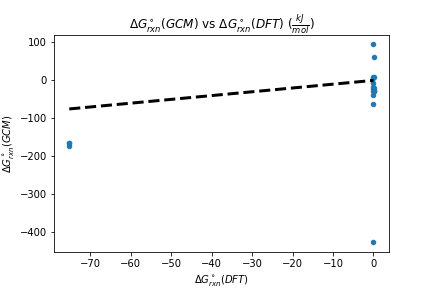

In [11]:
from IPython.display import Image, HTML
Image('Dataset/GCM_vs_QM9.png')

## $\Delta G^\circ_{rxn}(DFT)$ vs $\Delta G^\circ_{rxn}$(MPNNv2,chemgraph)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
friendly_rxns = pd.read_table('Dataset/friendly-metacyc-rxns.tab',index_col='FrameId')

deltaG.plot(y='$\Delta G^\circ_{rxn}$(MPNNv2,chemgraph)',
            x='$\Delta G^\circ_{rxn}(DFT)$',
            kind='scatter',
            title=r'$\Delta G^\circ_{rxn}$(MPNNv2,chemgraph) vs $\Delta G^\circ_{rxn}(DFT)$ ($\frac{kJ}{mol}$)',
        )

identity_line = np.linspace(max(deltaG['$\Delta G^\circ_{rxn}$(MPNNv2,chemgraph)'].min(), 
                                deltaG['$\Delta G^\circ_{rxn}(DFT)$'].min()),
                            min(deltaG['$\Delta G^\circ_{rxn}$(MPNNv2,chemgraph)'].max(), 
                                deltaG['$\Delta G^\circ_{rxn}(DFT)$'].max()))
plt.plot(identity_line, identity_line, color="black", linestyle="dashed", linewidth=3.0)

plt.savefig('Dataset/MPNNv2_chemgraph_vs_QM9.png')

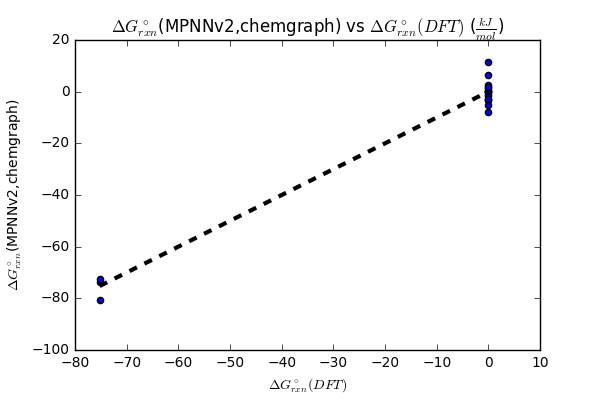

In [12]:
Image('Dataset/MPNNv2_chemgraph_vs_QM9.png')